## Loading Dataset using tf

In [1]:
# Importing essential libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 15

In [3]:
df = tf.keras.preprocessing.image_dataset_from_directory("dataset",
                                                         shuffle = True,
                                                          image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                          batch_size = BATCH_SIZE
                                                         )

Found 16011 files belonging to 10 classes.


In [4]:
#Classes of diseases 
class_names = df.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Two_spotted_spider_mite',
 'Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

Here, the folders or repositories that contain the separate plant images are class names








.

### Let's count the number of image samples in each class

In [5]:
import os

# Get the class names from the subdirectories in the dataset directory
class_names = sorted(os.listdir("dataset"))

# Count the number of samples in each class
samples_per_class = []
for class_name in class_names:
    class_dir = os.path.join("dataset", class_name)
    samples = len(os.listdir(class_dir))
    samples_per_class.append(samples)

# Print the class names and the number of samples
print("Class Samples:")
for class_name, samples in zip(class_names, samples_per_class):
    print(f"{class_name}: {samples} samples")


Class Samples:
Tomato_Bacterial_spot: 2127 samples
Tomato_Early_blight: 1000 samples
Tomato_Late_blight: 1909 samples
Tomato_Leaf_Mold: 952 samples
Tomato_Septoria_leaf_spot: 1771 samples
Tomato_Two_spotted_spider_mite: 1676 samples
Tomato_YellowLeaf__Curl_Virus: 3209 samples
Tomato__Target_Spot: 1404 samples
Tomato__Tomato_mosaic_virus: 373 samples
Tomato_healthy: 1591 samples


In [7]:
#let's findout the total number of image samples
total_samples = sum(samples_per_class)
print("Total number of samples:", total_samples)


Total number of samples: 16012


In [5]:
len(df)

501

Actual Length

In [6]:
501 * 32

16032

In [7]:
#1st image of the dataset 1 batch = 32 images
for image_batch, label_batch in df.take(1):
        print(image_batch[0].shape)


(256, 256, 3)


256*256 size and 3 rgb

In [8]:
for image_batch, labels_batch in df.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 0 0 6 2 3 6 6 7 2 4 5 5 6 6 2 1 0 3 6 0 4 7 9 0 9 9 2 2 2 3]


### Visualization of some of the images from our dataset

Displaying the 1st image

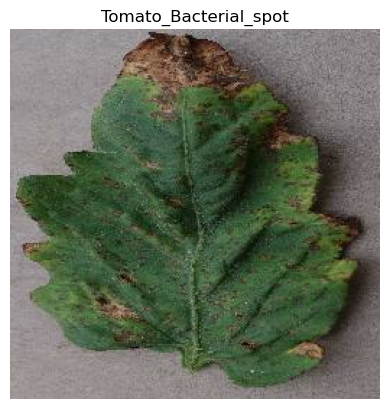

In [9]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

Displaying multiple images with their categories

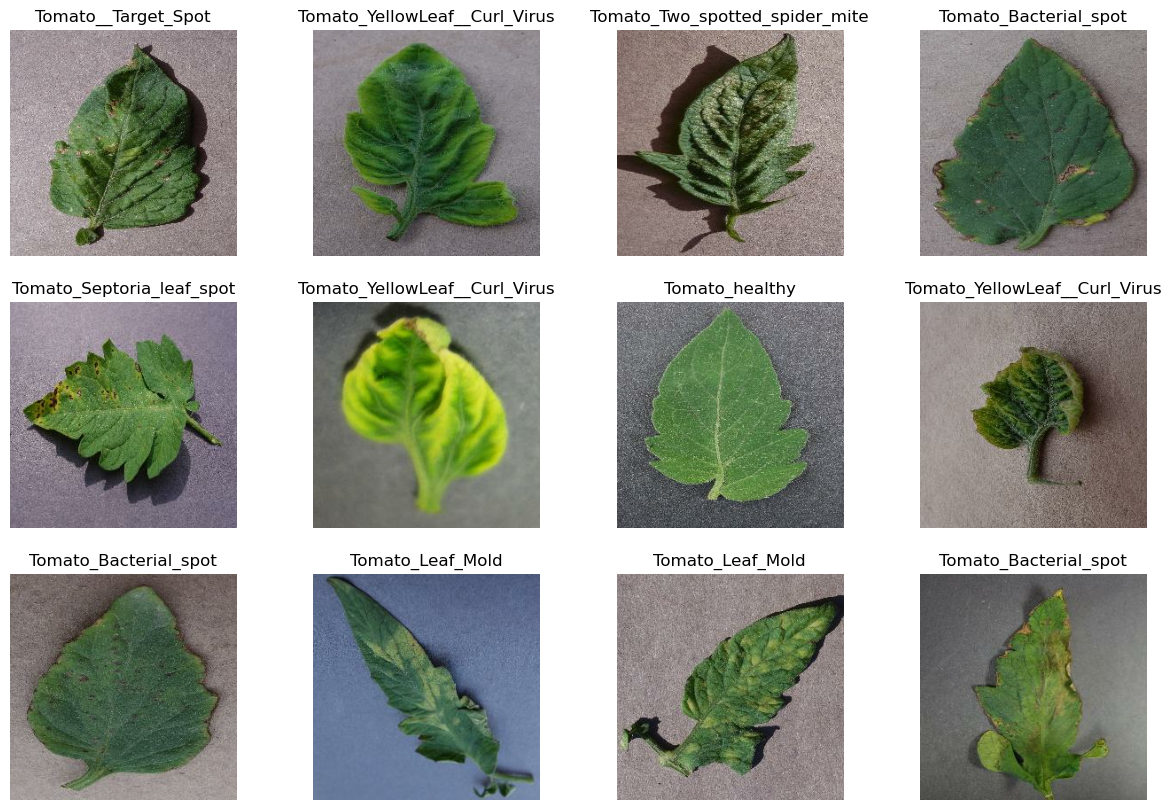

In [10]:
plt.figure(figsize=(15, 10))
for image_batch, labels_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [11]:
len(df)

501

The actual length is 501*32 
Each element is 32 batch

### Spiting dataset into training and testing 

80% = training 

20% = 10% validation, 10% testing 

In [12]:
# 80%(0.8) of total len(df) =  80% of 501
train_size = 0.8      # 0.8 means 80% (80/100)      
len(df)*train_size

400.8

So, Taking first 400 batches out of 501 batches

In [13]:
train_ds = df.take(400)  
len(train_ds)

400

train dataset = 400

In [14]:
test_ds = df.skip(400)# skipping first 400 and last 400
len(test_ds)

101

skipping first 350 and getting remaining 400 samples

In [15]:
val_size = 0.1
len(df)*val_size

50.1

10% of the actual dataset is 50.1


### Taking 50 samples of the test dataset

In [16]:
# Taking 50 samples from the test dataset
val_ds = test_ds.take(50)
len(val_ds)

50

Validation dataset = 50

In [17]:
#doing skip to get actual dataset
test_ds = test_ds.skip(50)
len(test_ds)

51

test dataset = 51

### Creating python function
- to take tensorflow dataset and split ratio

In [18]:
def get_df_partitions_tf(ds, train_split=0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000 ):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    


80% train
10% validation
10% test

In [19]:
train_ds, val_ds, test_ds = get_df_partitions_tf(df)


In [20]:
len(train_ds)

400

In [21]:
len(val_ds)

50

In [22]:
len(test_ds)

51

### Optimizing for training performance
Cache, Shuffle, and Prefetch the Dataset


In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model
#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

It might be confusing why do we need to resize (256,256) image to again (256,256). Though it doesn't need to but this will be useful when the training is completed and start using the model for predictions. At that time if an image is supplied that is not (256,256) and this layer will resize it.

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset


In [26]:
#train_ds = train_ds.map(
 #   lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture 
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. 

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [29]:
 model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
   
)

Epoch 1/15
400/400 [==============================] - 1024s 2s/step - loss: 1.5791 - accuracy: 0.4391 - val_loss: 0.9489 - val_accuracy: 0.6444
Epoch 2/15
400/400 [==============================] - 791s 2s/step - loss: 0.8158 - accuracy: 0.7159 - val_loss: 0.6133 - val_accuracy: 0.7825
Epoch 3/15
400/400 [==============================] - 791s 2s/step - loss: 0.5480 - accuracy: 0.8100 - val_loss: 0.4906 - val_accuracy: 0.8288
Epoch 4/15
400/400 [==============================] - 793s 2s/step - loss: 0.4117 - accuracy: 0.8566 - val_loss: 0.3189 - val_accuracy: 0.8938
Epoch 5/15
400/400 [==============================] - 788s 2s/step - loss: 0.3215 - accuracy: 0.8900 - val_loss: 0.3025 - val_accuracy: 0.8925
Epoch 6/15
400/400 [==============================] - 792s 2s/step - loss: 0.2646 - accuracy: 0.9123 - val_loss: 0.2844 - val_accuracy: 0.8969
Epoch 7/15
400/400 [==============================] - 795s 2s/step - loss: 0.2451 - accuracy: 0.9161 - val_loss: 0.1897 - val_accuracy: 0.935

In [31]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 110s 428ms/step - loss: 0.0762 - accuracy: 0.9779


In [32]:
history 

In [33]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 400}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.4390625059604645,
 0.7158593535423279,
 0.8100000023841858,
 0.856640636920929,
 0.8899999856948853,
 0.9122655987739563,
 0.9160937666893005,
 0.9320312738418579,
 0.9396874904632568,
 0.9486718773841858,
 0.9508593678474426,
 0.9565625190734863,
 0.9620312452316284,
 0.9637500047683716,
 0.9703906178474426]

In [36]:
len(history.history['accuracy'])

15

### Plotting the Accuracy and Loss Curves

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

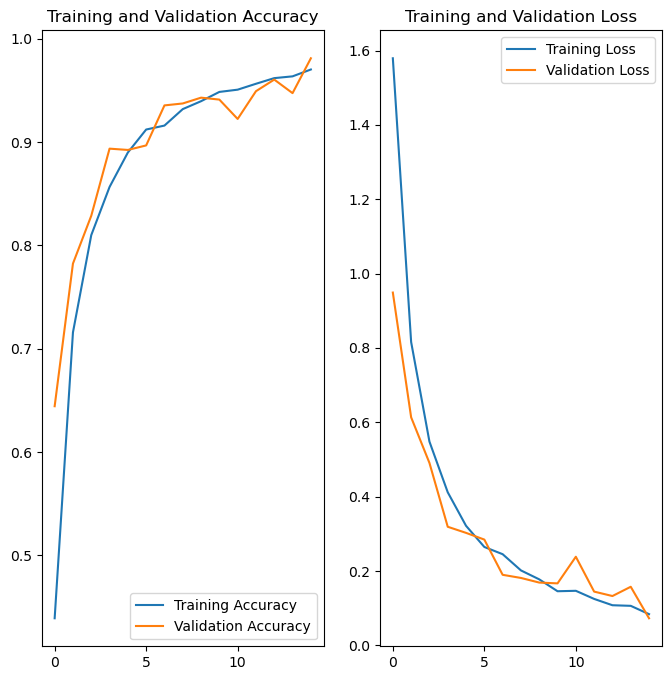

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 ### Run prediction on a sample image

first image to predict
actual label: Tomato_Septoria_leaf_spot
1/1 [==============================] - 2s 2s/step
predicted label: Tomato_Septoria_leaf_spot


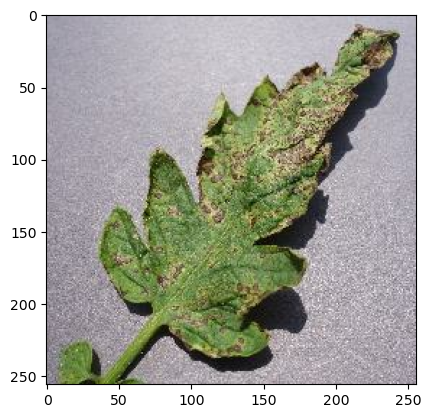

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 31ms/step


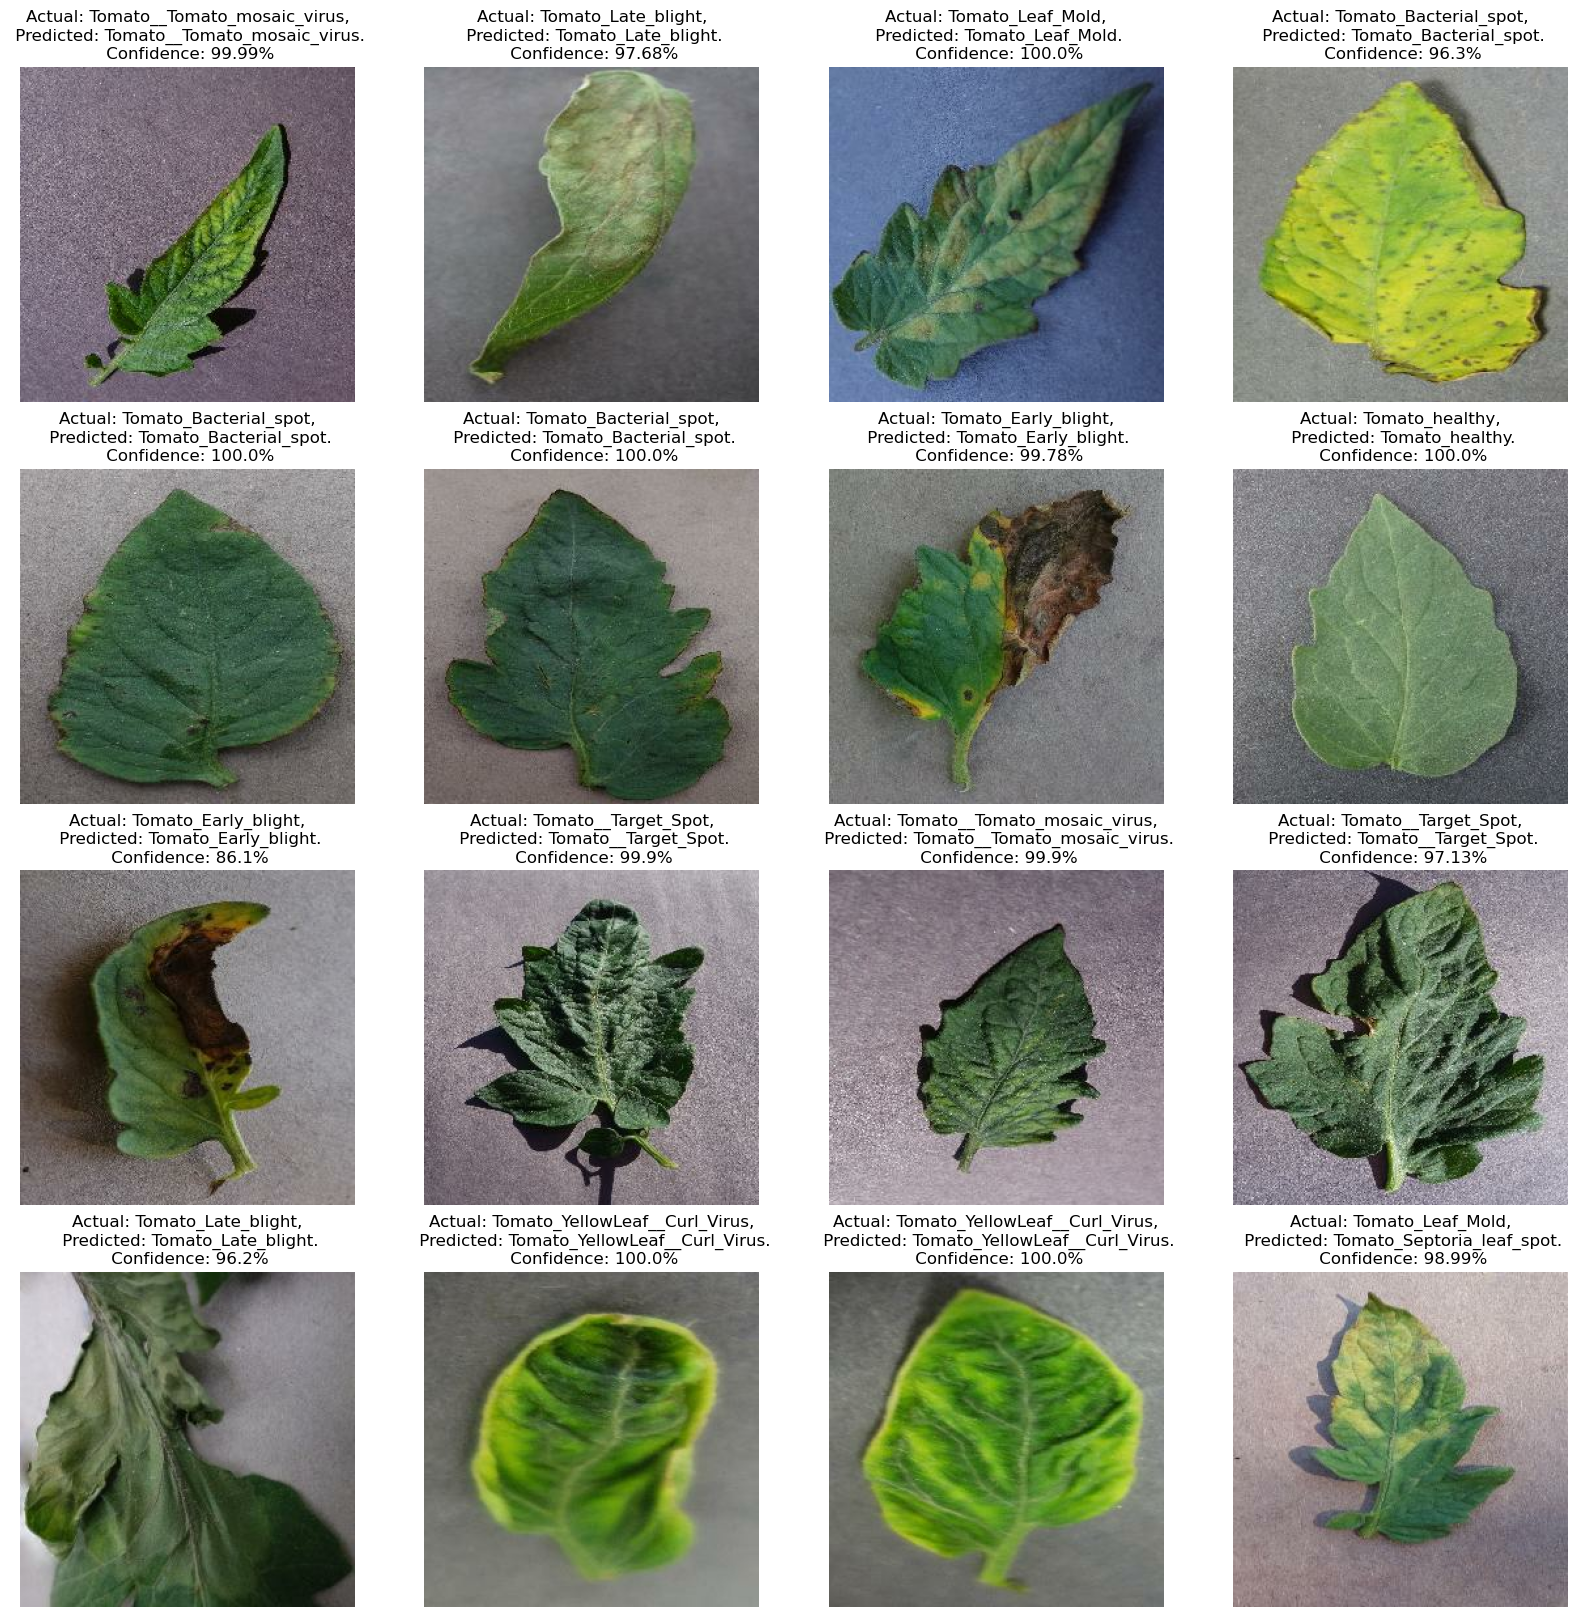

In [41]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [42]:
#import os
#model_version=max([int(i) for i in os.listdir("model") + [0]])+1
#model.save(f"model/{model_version}")

In [43]:
#model.save("../tomato.h5")

In [48]:
model.save('tomato1.h5')

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Make predictions on the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    batch_predictions = model.predict(images)
    y_true.extend(labels)
    y_pred.extend(np.argmax(batch_predictions, axis=1))

# Convert the labels to class names
y_true = [class_names[label] for label in y_true]
y_pred = [class_names[label] for label in y_pred]

# Calculate classification metrics
classification_metrics = classification_report(y_true, y_pred)
confusion_mtx = confusion_matrix(y_true, y_pred)

# Display the metrics
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_metrics)
print("\nConfusion Matrix:\n", confusion_mtx)


1/1 [==============================] - 0s 428ms/step
Test Loss: 0.07618577778339386
Test Accuracy: 0.9779411554336548

Classification Report:
                                 precision    recall  f1-score   support

         Tomato_Bacterial_spot       0.99      0.97      0.98       219
           Tomato_Early_blight       0.97      0.92      0.94        83
            Tomato_Late_blight       0.96      0.98      0.97       190
              Tomato_Leaf_Mold       0.98      0.98      0.98       103
     Tomato_Septoria_leaf_spot       0.97      1.00      0.98       201
Tomato_Two_spotted_spider_mite       0.99      0.96      0.98       170
 Tomato_YellowLeaf__Curl_Virus       1.00      0.99      1.00       329
           Tomato__Target_Spot       0.92      0.97      0.94       146
   Tomato__Tomato_mosaic_virus       1.00      0.97      0.99        35
                Tomato_healthy       1.00      0.98      0.99       156

                      accuracy                           0.98  

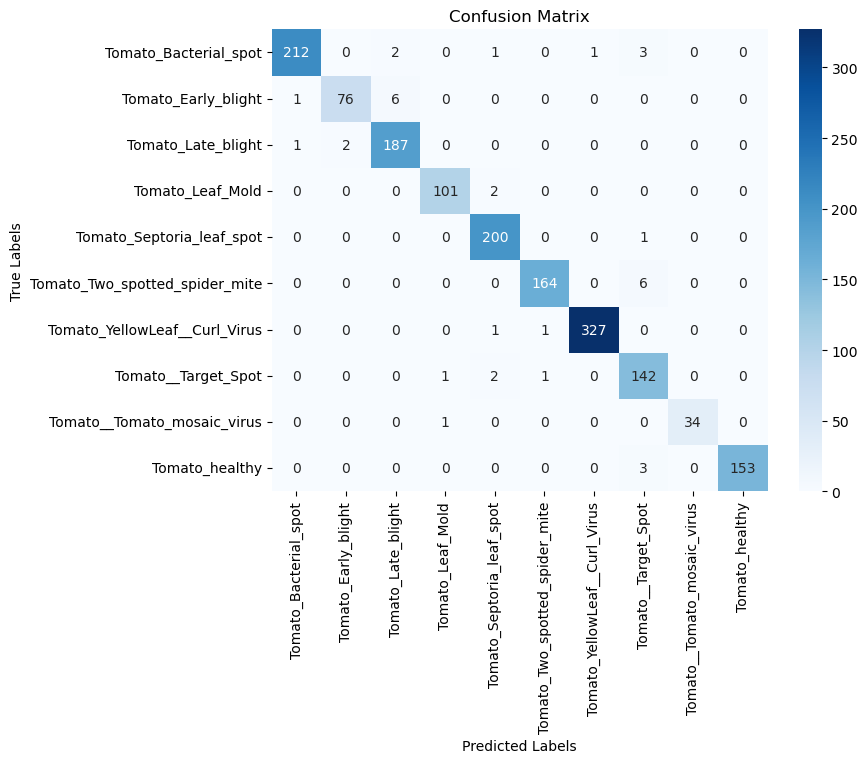

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Get the class names
class_names = sorted(set(y_true))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
